# Part I: Percolation
---
## Task Allocation
- Sihan Ren

## Description
We use Monte Carlo simulation to estimate percolation threshold. The task will consist of the following parts:
1. Simulation of percolation process
2. Monte Carlo simulation
3. Comparison


## 1.Simulation of percolation process
Under the guidance of the project specification, we construct an $n\times n$ grid to simulate percolation. At each step, we let a random site open and check once to see if the grid percolate. At last, use the fraction of sites that are opened when percolates as the probability $p$, which represents the probability that a site is open in the original problem. Our code is implemented as follows:
- Using a $n\times n$ np_array `_grid` to represent the grid, if `_grid[i][j]==0` the $(i,j)$ site is blocked, otherwise `_grid[i][j]==1` means $(i,j)$ site is opened.
- Given $n$, the `PercolationGrid` class is initialized. We first initialize an $n\times n$ np_array with all zero, and then we'll record the coordinates of each site using a list `block_list` and shuffle it.
- When we need to open a site, just pop the first item of `block_list`, then set the value of coorsponding site in the grid to one. At the same time, we'll update `open_num` to keep track of how many sites are currently opened. 
- To check if the grid has percolated, we adopt **BFS** algorithm. First we add a row to the top of the grid so that they all have the value 1, i.e., accessible. We then run the BFS algorithm starting from the added row. If the element in row n is accessed during the BFS process, then the grid is percolate.
- By calling `make_percolate()`, we are opening the site until it reaches percolate. It will returns the number of open sites.


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

class PercolationGrid():
    def __init__(self, size):
        self.len = size
        self._grid = np.zeros((size, size))
        self.open_num = 0
        self.percolates = False
        
        block_list = [(i, j) for i in range(size) for j in range(size)]
        random.shuffle(block_list)
        self._block_list = block_list
        # print(block_list)     
        
    def open_block(self):
        if len(self._block_list)==0:
            raise Exception("No more blocks to open")
        i, j = self._block_list.pop()
        self._grid[i, j] = 1
        self.open_num += 1
    
    def BFS(self,grid,n,vis=False):
        # In the grid, 1 means open, 0 means blocked, 2 means visited
        
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

        # add a new row on the top, we start from this row
        grid = np.vstack([np.full(n, 2), grid])
        queue = deque([(0, i) for i in range(n)])

        bound_r = n+1
        bound_c = n

        while queue:
            r, c = queue.popleft()
            if r == n and not vis:
                return True, grid
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < bound_r and 0 <= nc < bound_c and grid[nr, nc] == 1:
                    queue.append((nr, nc))
                    grid[nr, nc] = 2
        return False, grid
    
    def check_percolates(self):
        self.percolates,_ = self.BFS(np.copy(self._grid), self.len)
        return self.percolates
    
    def visualize(self, ax):
        vis_grid = np.copy(self._grid)
        _, vis_grid = self.BFS(vis_grid, self.len, vis=True)
        vis_grid = vis_grid[1:, :]
        
        color_map = {1: 'white', 0: 'black', 2: '#ADD8E6'}
        n = self.len

        ax.set_xlim(0, n)
        ax.set_ylim(0, n)
        ax.set_xticks(range(n+1))
        ax.set_yticks(range(n+1))
    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True)

        for x in range(n):
            for y in range(n):
                ax.add_patch(plt.Rectangle((y, n-x-1), 1, 1, color=color_map[vis_grid[x, y]]))
        return ax
    
    def make_percolate(self):
        while not self.check_percolates():
            self.open_block()
        return self.open_num

- Here is an example of the percolation process with $n=20$:

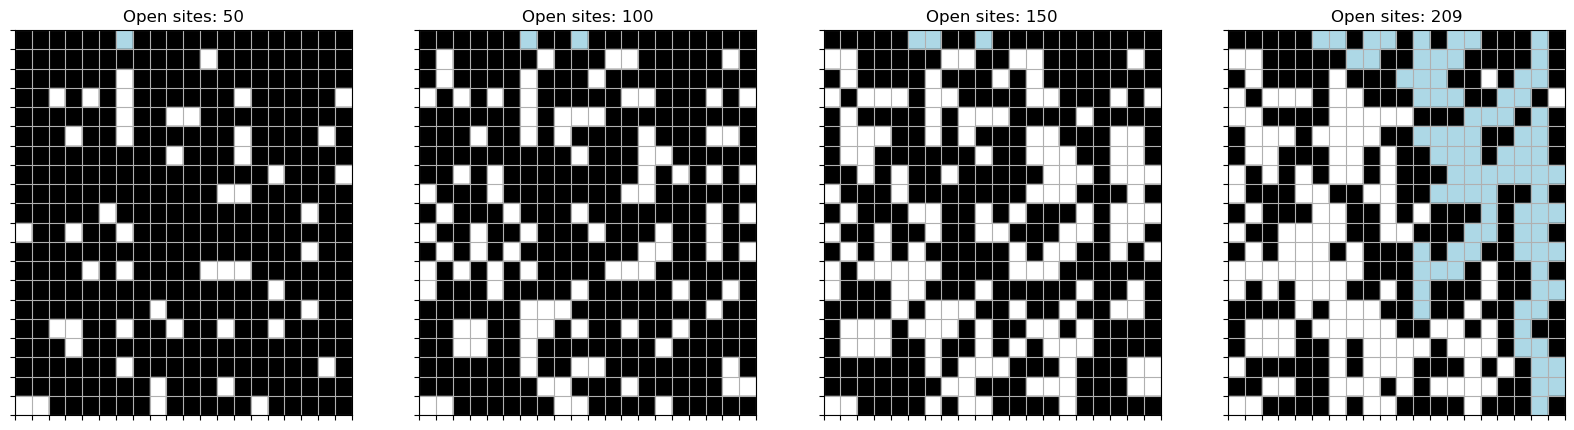

In [63]:
example = PercolationGrid(20)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    for k in range(50):
        if example.check_percolates(): break
        example.open_block()
    if i == 3:
        example.make_percolate()
    example.visualize(axs[i])
    axs[i].set_title(f'Open sites: {example.open_num}')

plt.show()


## 2.Monte Carlo simulation
In this part, we will conduct simulation with n=20,50, and 100, respectively. Let $x_t$ be the fraction of open sites in simulation $t$ and $s_t$ denote the number of opened sites, then we use sample mean to estimate the percolation threshold. We have
$$
x_t = \frac{s_t}{n^2}
$$

$$
p^* \approx \bar{x}=\frac{x_1+x_2+\ldots+x_T}{T}=\frac{s_1+s_2+\ldots+s_T}{n^2 T}
$$

In [64]:
T = 1000

def MC_Simulation(grid_len, times):
    '''
    grid_len: The length of the grid. The grid will be grid_len*grid_len
    times: The number of simulations: the T in x_bar=1/T*sum_{t=1}^T x_t
    '''
    open_num = 0
    for i in tqdm(range(times)):
        grid = PercolationGrid(grid_len)
        open_num += grid.make_percolate()
    return (open_num/grid_len**2) / times
    
for n in [20, 50, 100]:
    print(f'Grid size: {n}-by-{n}')
    print(f'Estimated threshold: {MC_Simulation(n, T)}')
    print('-------------------------')

Grid size: 20-by-20


100%|██████████| 1000/1000 [00:10<00:00, 92.54it/s]


Estimated threshold: 0.5910599999999999
-------------------------
Grid size: 50-by-50


 12%|█▏        | 119/1000 [00:21<02:38,  5.56it/s]


KeyboardInterrupt: 

## 3.Comparison
In this section, we will compare the effect of the number of simulation on the results ( i.e. $T$ ). We will compare the results obtained with the number of simulation from 1 to 5000  (Because we found that after about 5,000 simulations the change was very small). And according to project specification, we have a prior that $p^* \approx 0.593$. Thus for each size of grid, we will show: for $t\in(0,5000]$
- The results of their estimation after t steps of simulations $\hat{p}^*_t$. 
- The gap $l(t)$ between their estimated results and $p^*=0.593$ after t steps of experiment. We will use $l(t)=|\hat{p}^*_t-p^*|$

In [ ]:
TT = 5000
p_prior = 0.593

def MC_Simulation2(grid_len, times):
    open_num = 0
    estimated_p_t_values = []
    for t in tqdm(range(1,times+1)):
        grid = PercolationGrid(grid_len)
        grid.make_percolate()
        open_num += grid.open_num
        estimated_p_t = (open_num/grid_len**2) / t
        estimated_p_t_values.append(estimated_p_t)
    
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1,2,1)
    plt.plot(range(times), estimated_p_t_values)
    plt.axhline(y=p_prior, color='r', linestyle='--')
    plt.xlabel('t')
    plt.ylabel('estimated_p')
    

    
    plt.subplot(1,2,2)
    plt.plot(range(times), [abs(p - p_prior) for p in estimated_p_t_values])
    plt.xlabel('t')
    plt.ylabel('|estimated_p - p_prior|')
    plt.show()

     
for n in [20, 50, 100]:
    print(f'Grid size: {n}-by-{n}')
    MC_Simulation2(n, TT)
    print('-------------------------')